## Is a good beer a good beer everywhere?

How do liked beers differ locally and globally (maybe choose the most “important” beers and show on the map in different colors/shadings how popular they are in the different states)?

In [1]:
import pandas as pd
import numpy as np
import gzip #to read gzip files
import matplotlib.pyplot as plt
import datetime

### Data extraction from the different rating websites (beers, breweries and users)

In [2]:
PATH = '../'

In [3]:
BA_beers = pd.read_csv(PATH+'BeerAdvocate/beers.csv', index_col='beer_id')
BA_beers.head(2)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN


In [4]:
matched_beers = pd.read_csv(PATH+'matched_beer_data/beers.csv', header=1)
matched_beers.head(2)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.000000,1.0
1,6.0,3.86,3.888750,3.768333,NaN,20841,St. Patrick's Ale,Patricks Ale St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,11,11,52.0,Irish Ale,79.0,0.005754,0.527141,1.0


In [5]:
BA_breweries = pd.read_csv(PATH+'BeerAdvocate/breweries.csv', index_col='id')
BA_breweries.head(2)

,location,name,nbr_beers
id,,,
39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
39913,Kyrgyzstan,Arpa (АРПА),1


In [6]:
RB_breweries = pd.read_csv(PATH+'RateBeer/breweries.csv', index_col= 'id')
RB_breweries.head(2)

,location,name,nbr_beers
id,,,
3198,Gabon,Sobraga,3
13538,Northern Ireland,Ards Brewing Co.,13


In [7]:
matched_breweries = pd.read_csv(PATH+'matched_beer_data/breweries.csv', header=1)
matched_breweries.head(2)

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596


In [8]:
BA_users = pd.read_csv(PATH+'BeerAdvocate/users.csv', index_col= 'user_id')
BA_users['joined'] = pd.to_datetime(BA_users['joined'],unit = 's')
BA_users.head(2)

,nbr_ratings,nbr_reviews,user_name,joined,location
user_id,,,,,
nmann08.184925,7820,465,nmann08,2008-01-07 11:00:00,"United States, Washington"
stjamesgate.163714,2521,2504,StJamesGate,2007-10-08 10:00:00,"United States, New York"


In [9]:
RB_users = pd.read_csv(PATH+'RateBeer/users.csv', index_col= 'user_id')
RB_users['joined'] = pd.to_datetime(RB_users['joined'] ,unit = 's')
RB_users.head(2)

,nbr_ratings,user_name,joined,location
user_id,,,,
175852,1890,Manslow,2012-05-20 10:00:00,Poland
442761,89,MAGICuenca91,2017-01-10 11:00:00,Spain


In [10]:
matched_users = pd.read_csv(PATH+'matched_beer_data/users.csv', header=1)
matched_users['joined'] = pd.to_datetime(matched_users['joined'],unit = 's')
matched_users['joined.1'] = pd.to_datetime(matched_users['joined.1'],unit = 's')
matched_users.head(2)

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,2008-09-08 10:00:00,Germany,6,6,erzengel.248045,Erzengel,erzengel,2008-10-18 10:00:00,Germany,8781,83106,Erzengel,erzengel
1,2012-09-23 10:00:00,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,2013-11-29 11:00:00,"United States, Virginia",6240,290599,GenDV138,gendv138


### Extracting BA reviews

In [100]:
#open the csv file
df_BA_reviews = pd.read_csv('../BeerAdvocate/df_BA_reviews.csv')
df_BA_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...


# Extracting RB ratings:

In [12]:
#open the csv file
df_RB_reviews = pd.read_csv('../RateBeer/df_RB_reviews_final.csv')
df_RB_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...


## Extracting matched data ratings

In [13]:
MD_ratings = pd.read_csv(PATH+'matched_beer_data/ratings.csv', header = 1)
MD_ratings.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
1,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,...,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing


## Choosing the 20 best beers in the world

Different chosen criteria:
1) Beers that have receieved at least x number of reviews 
2) Reviewers that have reviewed more than x amount of times (if someone rated a beer once only it's maybe not enough), also we haev to keep in mind that a lot of people midlessly put ratings but no reviews, hence here we focus on the number of reviews because it means the person put the effort to write a review, making the overall rating more legitimate
3) Extract top 20 beers according to the avg rating over the two websites

### 1) Beers that have recieved a significant number of reviews

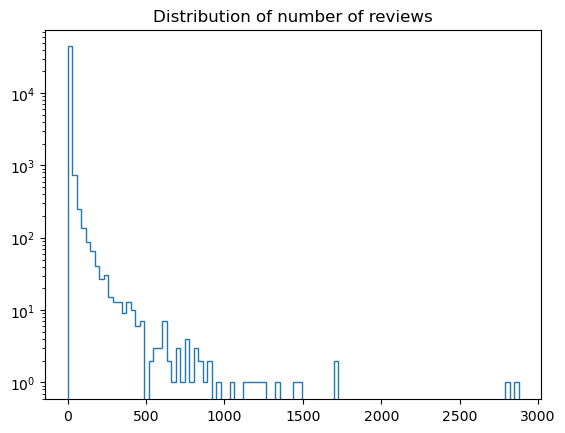

In [26]:
array_100=plt.hist(matched_beers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of number of reviews')
plt.show()
#heavy taield distribution for the number of reviews

In [27]:
# First, we decide to take beers which have recieved more than 50 reviews
top_beers = matched_beers[matched_beers['nbr_reviews']>50]
len(top_beers)

890

In [28]:
#We extract the corresponding ratings/reviews from matched data 
top_beers_ratings = MD_ratings[MD_ratings['beer_id'].isin(top_beers['beer_id']) | MD_ratings['beer_id.1'].isin(top_beers['beer_id.1'])]

In [29]:
len(top_beers_ratings) #there are the same beers several times 

10091

In [30]:
top_beers_ratings.columns

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'review',
       'style', 'taste', 'text', 'user_id', 'user_name', 'abv.1',
       'appearance.1', 'aroma.1', 'beer_id.1', 'beer_name.1', 'brewery_id.1',
       'brewery_name.1', 'date.1', 'overall.1', 'palate.1', 'rating.1',
       'style.1', 'taste.1', 'text.1', 'user_id.1', 'user_name.1'],
      dtype='object')

### 2) Reviewers that have reviewed more than x amount of times 

In [31]:
#we extract the users that reviewed the beers that have received more than 50 reviews.
top_beers_reviewers = matched_users[matched_users['user_id'].isin(top_beers_ratings['user_id']) | matched_users['user_id.1'].isin(top_beers_ratings['user_id.1'])]

In [32]:
top_beers_reviewers['nbr_ratings'].describe()

count      711.000000
mean       589.303797
std       1189.291214
min          1.000000
25%         35.000000
50%        173.000000
75%        544.500000
max      12046.000000
Name: nbr_ratings, dtype: float64

In [33]:
#We decide to filter by the reviewers that have put a number of reviews (not ratings) higher than the third percentile
top_beers_reviewers = top_beers_reviewers.loc[top_beers_reviewers['nbr_reviews']>544]

In [34]:
#filtering the beer ratings by the top beer reviewers
top_beers_ratings = top_beers_ratings[top_beers_ratings['user_id'].isin(top_beers_reviewers['user_id']) & top_beers_ratings['user_id.1'].isin(top_beers_reviewers['user_id.1']) ]

### 3) Extract top 20 beers according to the avg rating over the two websites

In [35]:
len(top_beers[top_beers['beer_id'].isin(top_beers_ratings['beer_id']) & top_beers['beer_id.1'].isin(top_beers_ratings['beer_id.1']) ])

873

In [36]:
#adding an average of averages column to get the average rating across both websites
top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)
top_20_beers = top_beers.nlargest(20, 'average_avg', keep='all')

C:\Users\flori\AppData\Local\Temp\ipykernel_13076\1016610164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)


In [37]:
top_20_beers.columns

Index(['abv', 'avg', 'avg_computed', 'avg_matched_valid_ratings', 'ba_score',
       'beer_id', 'beer_name', 'beer_wout_brewery_name', 'brewery_id',
       'brewery_name', 'bros_score', 'nbr_matched_valid_ratings',
       'nbr_ratings', 'nbr_reviews', 'style', 'zscore', 'abv.1', 'avg.1',
       'avg_computed.1', 'avg_matched_valid_ratings.1', 'beer_id.1',
       'beer_name.1', 'beer_wout_brewery_name.1', 'brewery_id.1',
       'brewery_name.1', 'nbr_matched_valid_ratings.1', 'nbr_ratings.1',
       'overall_score', 'style.1', 'style_score', 'zscore.1', 'diff', 'sim',
       'average_avg'],
      dtype='object')

In [38]:
top_beers_ratings.columns

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'review',
       'style', 'taste', 'text', 'user_id', 'user_name', 'abv.1',
       'appearance.1', 'aroma.1', 'beer_id.1', 'beer_name.1', 'brewery_id.1',
       'brewery_name.1', 'date.1', 'overall.1', 'palate.1', 'rating.1',
       'style.1', 'taste.1', 'text.1', 'user_id.1', 'user_name.1'],
      dtype='object')

In [39]:
#We extract the ratings for those top20 beers for the top reviewers
top_20_beers_ratings = top_beers_ratings[top_beers_ratings['beer_id'].isin(top_20_beers['beer_id']) & top_beers_ratings['beer_id.1'].isin(top_20_beers['beer_id.1'])]

In [40]:
len(top_20_beers_ratings)

269

In [244]:
#Checking that we do have the 20 beers
top_20_beers_ratings[['beer_id','beer_id.1']].nunique()

beer_id      20
beer_id.1    20
dtype: int64

In [246]:
# Group by beer id's
top_20_beers_ratings = top_20_beers_ratings.set_index(['beer_id','beer_id.1'])

In [247]:
top_20_beers_ratings.index

abv  appearance  aroma                beer_name  \
beer_id beer_id.1                                                     
645     2360       11.3         5.0    5.0  Trappistes Rochefort 10   
        2360       11.3         3.5    4.0  Trappistes Rochefort 10   
3833    14232      12.0         4.0    4.0  AleSmith Speedway Stout   
645     2360       11.3         4.0    4.0  Trappistes Rochefort 10   
3833    14232      12.0         3.5    4.0  AleSmith Speedway Stout   

                   brewery_id              brewery_name        date  overall  \
beer_id beer_id.1                                                              
645     2360              207    Brasserie de Rochefort  1060855200      5.0   
        2360              207    Brasserie de Rochefort  1307181600      4.5   
3833    14232             396  AleSmith Brewing Company  1388487600      4.5   
645     2360              207    Brasserie de Rochefort  1070708400      4.0   
3833    14232             396  AleSmith Brewing Company  1079953200      4.0   

                   palate  rating  ...            brewery_name.1      date.1  \
beer_id beer_id.1                  ...                                         
645     2360         5.00    5.00  ...       Brasserie Rochefort  1060855200   
        2360         4.50    4.32  ...       Brasserie Rochefort  1334138400   
3833    14232        4.25    4.33  ...  AleSmith Brewing Company  1388487600   
645     2360         4.00    4.20  ...       Brasserie Rochefort  1123927200   
3833    14232        4.00    3.77  ...  AleSmith Brewing Company  1101639600   

                   overall.1 palate.1 rating.1         style.1  taste.1  \
beer_id beer_id.1                                                         
645     2360            20.0      5.0      5.0   Abt/Quadrupel     10.0   
        2360            18.0      4.0      3.9   Abt/Quadrupel      8.0   
3833    14232           17.0      4.0      4.2  Imperial Stout      9.0   
645     2360            16.0      4.0      3.9   Abt/Quadrupel      8.0   
3833    14232           15.0      4.0      3.9  Imperial Stout      8.0   

                                                              text.1  \
beer_id beer_id.1                                                      
645     2360       (330 ml bottle). Pours with an enormous and th...   
        2360       33cl Bottle, been with me for a while, best be...   
3833    14232      Early on 31st Dec 13, usual 0.75 litre bottle ...   
645     2360        update March 1st, 2004  Massive beer. Nocturn...   
3833    14232       Blind Tasting, Thanks tiggmtl  Pitch black po...   

                   user_id.1   user_name.1  
beer_id beer_id.1                           
645     2360            3343       Sigmund  
        2360           97853  BlackHaddock  
3833    14232          97853  BlackHaddock  
645     2360            8034   Rastacouere  
3833    14232           8034   Rastacouere  

[5 rows x 31 columns]

In [218]:
beer_multiindex = top_20_beers_ratings.index

In [251]:
unique_beer_ids = top_20_beers_ratings.index.drop_duplicates()

In [254]:
beer_locations = pd.DataFrame(columns=['beer_id','beer_id.1','brewery_location','brewery_location.1'])
user_locations = pd.DataFrame(columns=['beer_id', 'beer_id.1', 'user_id', 'user_id.1','user_location', 'user_location.1'])

In [265]:
top_20_beers_ratings.columns

Index(['abv', 'appearance', 'aroma', 'beer_name', 'brewery_id', 'brewery_name',
       'date', 'overall', 'palate', 'rating', 'review', 'style', 'taste',
       'text', 'user_id', 'user_name', 'abv.1', 'appearance.1', 'aroma.1',
       'beer_name.1', 'brewery_id.1', 'brewery_name.1', 'date.1', 'overall.1',
       'palate.1', 'rating.1', 'style.1', 'taste.1', 'text.1', 'user_id.1',
       'user_name.1'],
      dtype='object')

In [266]:
beer_locations_test = top_20_beers_ratings[~top_20_beers_ratings.index.duplicated(keep='first')][['brewery_id','brewery_id.1','user_id','user_id.1']] 

In [271]:
beer_locations_test

,,brewery_id,brewery_id.1,user_id,user_id.1
beer_id,beer_id.1,,,,
645,2360,207,406,sigmund.323,3343
3833,14232,396,432,blackhaddock.90923,97853
5281,7502,388,1069,rastacouere.3633,8034
69522,145903,22511,11233,boto.1987,154
117177,258973,17980,9863,boto.1987,154
8983,21457,2216,2058,callmemickey.152731,92897
64545,134550,17980,9863,callmemickey.152731,92897
47088,95636,388,1069,callmemickey.152731,92897
36316,66438,388,1069,callmemickey.152731,92897


In [280]:
brewery_locations = matched_breweries[matched_breweries['id'].isin(beer_locations_test['brewery_id']) & matched_breweries['id.1'].isin(beer_locations_test['brewery_id.1'])]
brewery_locations = brewery_locations[['id','id.1','location', 'location.1']]

In [283]:
brewery_locations.set_index(['id','id.1'])

,,location,location.1
id,id.1,,
396,432,"United States, California","United States, California"
20680,10514,"United States, Washington","United States, Washington"
26676,13267,"United States, New Jersey","United States, New Jersey"
23222,11242,"United States, Iowa","United States, Iowa"
22511,11233,"United States, Vermont","United States, Vermont"
17980,9863,"United States, Vermont","United States, Vermont"
20681,10659,"United States, Maine","United States, Maine"
33519,18813,"United States, Maine","United States, Maine"
207,406,Belgium,Belgium


In [236]:
top_20_beers.loc[ (top_20_beers['beer_id'] == 645) & (top_20_beers['beer_id.1'] == 2360)][['brewery_id','brewery_id.1']]

,brewery_id,brewery_id.1
43246,207,406


In [235]:
top_20_breweries

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
4067,396,"United States, California",AleSmith Brewing Company,288,432,"United States, California",AleSmith Brewing Company,261,0.658297,1.000000
4469,20680,"United States, Washington",Fremont Brewing Company,176,10514,"United States, Washington",Fremont Brewing Company,191,0.360245,1.000000
4632,26676,"United States, New Jersey",Kane Brewing Company,228,13267,"United States, New Jersey",Kane Brewing Company,166,0.658297,1.000000
5818,23222,"United States, Iowa",Toppling Goliath Brewing Company,93,11242,"United States, Iowa",Toppling Goliath,84,0.719506,0.968504
6165,22511,"United States, Vermont",Hill Farmstead Brewery,222,11233,"United States, Vermont",Hill Farmstead Brewery,239,0.550189,1.000000
6171,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89,1.000000,1.000000
6459,20681,"United States, Maine",Maine Beer Company,48,10659,"United States, Maine",Maine Beer Company,44,0.305457,1.000000
6488,33519,"United States, Maine",Bissell Brothers Brewing Co.,37,18813,"United States, Maine",Bissell Brothers Brewing Company,29,0.423924,0.923321
7395,207,Belgium,Brasserie de Rochefort,3,406,Belgium,Brasserie Rochefort,3,0.531187,0.923711
7443,388,Belgium,Brasserie Cantillon,82,1069,Belgium,Cantillon,77,0.480277,0.905220


In [ ]:
beer_locations = []
breweries_locations = []

for i in beer_multiindex
    beer_breweries= top_20_beers.loc[ (top_20_beers['beer_id'] == beer_multiindex[i][0]) & (top_20_beers['beer_id.1'] ==  beer_multiindex[i][1])][['brewery_id','brewery_id.1']]
    

### Comparing breweries locations and reviewers location

In [185]:
#we extract the breweries that correspond to the top 20 beers
top_20_beers_breweries= matched_breweries[matched_breweries['id'].isin(top_20_beers['brewery_id']) & matched_breweries['id.1'].isin(top_20_beers['brewery_id.1'])]

In [186]:
# We observe that there are only 12 corresponding breweries because there are several beers produced by the same breweries
len(top_20_beers_breweries)

12

In [188]:
top_20_beers_breweries

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
4067,396,"United States, California",AleSmith Brewing Company,288,432,"United States, California",AleSmith Brewing Company,261,0.658297,1.000000
4469,20680,"United States, Washington",Fremont Brewing Company,176,10514,"United States, Washington",Fremont Brewing Company,191,0.360245,1.000000
4632,26676,"United States, New Jersey",Kane Brewing Company,228,13267,"United States, New Jersey",Kane Brewing Company,166,0.658297,1.000000
5818,23222,"United States, Iowa",Toppling Goliath Brewing Company,93,11242,"United States, Iowa",Toppling Goliath,84,0.719506,0.968504
6165,22511,"United States, Vermont",Hill Farmstead Brewery,222,11233,"United States, Vermont",Hill Farmstead Brewery,239,0.550189,1.000000
6171,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89,1.000000,1.000000
6459,20681,"United States, Maine",Maine Beer Company,48,10659,"United States, Maine",Maine Beer Company,44,0.305457,1.000000
6488,33519,"United States, Maine",Bissell Brothers Brewing Co.,37,18813,"United States, Maine",Bissell Brothers Brewing Company,29,0.423924,0.923321
7395,207,Belgium,Brasserie de Rochefort,3,406,Belgium,Brasserie Rochefort,3,0.531187,0.923711
7443,388,Belgium,Brasserie Cantillon,82,1069,Belgium,Cantillon,77,0.480277,0.905220


In [ ]:
top_20_beers.merge(top_20_beers_breweries)

Aligned data = matched breweries and matched beers so not same reviewer potentially 

Extraire les noms des reviewer  (user_id et user_id.1 sont les memes dans matched_users) + pays d'origine + le nb de REVIEWS qu'ils ont mis (1 et 2): filter selon si l'un ou l'autre a mis plus que x review -> filter top_beers avec ces users en utilisant MD_users

Extraire de top_beers les bieres top 22 avg (average des avg.1 et avg.2) + pays en utilisant brewery id 

trouver une raison pour le choix des treshold nbr of reviews

Repeter ca par region?

# Flos code:

## Chinas beers correlate with how US citizens view China:

In [17]:
print(len(RB_breweries[RB_breweries['location']=='China']))
print(len(BA_breweries[BA_breweries['location']=='China']))

188
66


In [23]:
chinese_breweries_RB = RB_breweries[RB_breweries['location']=='China']
chinese_breweries_BA = BA_breweries[BA_breweries['location']=='China']

In [21]:
#As the same breweries have not exactly the same wording, we concatenate the two dataframes.
chinese_breweries = pd.concat([chinese_breweries_RB['name'], (chinese_breweries_BA['name'])], axis=0)
chinese_breweries.head(1)

id
29441    申爱 Shanghai Love Brewing Co.
Name: name, dtype: object

In [24]:
df_BA_reviews.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ..."


In [25]:
len(df_BA_reviews[df_BA_reviews['brewery_name'].isin([chinese_breweries])])

0

In [26]:
len(df_RB_reviews[df_RB_reviews['brewery_name'].isin([chinese_breweries])])

0

There are no ratings about chinese beers neither in BA nor in RB.

## Influence of Brexit on british reviews in the US:

In [29]:
print(df_BA_reviews.date.max())
print(df_BA_reviews.date.min())

2017-08-01 10:00:00
1996-08-22 10:00:00


In [30]:
print(df_RB_reviews.date.max())
print(df_RB_reviews.date.min())

2017-07-31 10:00:00
2000-04-12 10:00:00


## Preprocessing

In [101]:
#Delete later
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")
BA_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)
df_BA_reviews = (df_BA_reviews.merge(BA_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})
BA_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)
df_BA_reviews['brewery_merged_location'] = df_BA_reviews['brewery_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

df_ratings_BA = (df_BA_reviews.merge(BA_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})



In [ ]:
#Transform the dates of the reviews from string to datetime
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [33]:
#Rename the column name to brewery_name to allow merging with the 
BA_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)
RB_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)


#Add the location to the beer dataframe
df_BA_reviews = (df_BA_reviews.merge(BA_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})
df_RB_reviews = (df_RB_reviews.merge(RB_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})


#Name the columns back: 
BA_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)
RB_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)

In [74]:
# Add a column where all breweries from the united states get 'United States' as location
df_RB_reviews['brewery_merged_location'] = df_RB_reviews['brewery_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'


df_BA_reviews['brewery_merged_location'] = df_BA_reviews['brewery_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

In [76]:
#Add the country of origin of the reviewer to the review
df_ratings_RB = (df_RB_reviews.merge(RB_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})
df_ratings_BA = (df_BA_reviews.merge(BA_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})

# Add a column where all users from the united states get 'United States' as location
df_ratings_RB['brewery_merged_location'] = df_ratings_RB['brewery_location'].copy()
df_ratings_RB.loc[(df_ratings_RB['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

#For BA we have to replace the NaN values
df_ratings_BA['user_location'] = df_ratings_BA['user_location'].fillna('Unknown')
df_ratings_BA['user_merged_location'] = df_ratings_BA['user_location'].copy()
df_ratings_BA.loc[(df_ratings_BA['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

In [50]:
'''df_BA_reviews = df_BA_reviews.loc[:, ~df_BA_reviews.columns.duplicated()]
df_RB_reviews = df_RB_reviews.loc[:, ~df_RB_reviews.columns.duplicated()]'''


### Get Reviews about british beer:

In [38]:
df_british_beers_RB = df_RB_reviews[(df_RB_reviews['brewery_location']=='Northern Ireland') |
                                (df_RB_reviews['brewery_location']=='Wales')  |
                                (df_RB_reviews['brewery_location']=='Scotland') |
                                (df_RB_reviews['brewery_location']=='England')]

df_british_beers_BA = df_BA_reviews[(df_BA_reviews['brewery_location']=='Northern Ireland') |
                                (df_BA_reviews['brewery_location']=='Wales')  |
                                (df_BA_reviews['brewery_location']=='Scotland') |
                                (df_BA_reviews['brewery_location']=='England')]

In [41]:
#count the number of beers we can work with.
print('in RB we have: ' + str(len(df_british_beers_RB)) + ' beers.')
print('in BA we have: ' + str(len(df_british_beers_BA)) + ' beers.')

in RB we have: 774523 beers.
in BA we have: 95800 beers.


In [70]:
brexit_date = datetime.datetime(2016, 6, 23, 0, 0, 0)


print('We have '+ str(len(df_british_beers_BA[df_british_beers_BA['date'] > brexit_date])) +' ratings of british beer in BA')
print('and '+ str(len(df_british_beers_RB[df_british_beers_RB['date'] > brexit_date])) +' ratings of british beer in RA after the brexit')
print('Meaning we can work with ' + str(len(df_british_beers_RB[df_british_beers_RB['date'] > brexit_date]) + len(df_british_beers_BA[df_british_beers_BA['date'] > brexit_date])) +' ratings.')

We have 4363 ratings of british beer in BA
and 107213 ratings of british beer in RA after the brexit
Meaning we can work with 111576 ratings.


# Visualize where most ratings were from:

In [109]:
#Do that only once. Stores the dataframes so that we can access them more easily next time and have to do the data preprocessing only once
df_ratings_BA.to_csv(PATH+'/dataframes_Flo/df_BA_ratings.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text'], index=False)

In [99]:
df_RB_reviews.to_csv(PATH+'/dataframes_Flo/df_RB_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text'], index=False)

# Code for Zeina:

In [ ]:
words_to_select_can = ['can', 'canned']
words_to_select_bottle = ['bottle', 'bottled']